# Conway's Game of Life - Parallel MPI Implementation

**Course:** Distributed Systems  
**Date:** November 30, 2025  
**HPC Platform:** Almesbar (KU)  

---

## 1. Introduction

This project implements Conway's Game of Life using MPI for parallel computation on large grids. 
**Two implementations are provided:** 1-D row decomposition (primary) and 2-D grid decomposition (bonus).

### Key Features
- **1-D Row Decomposition**: Grid split horizontally among MPI ranks (2 neighbors)
- **2-D Grid Decomposition**: Grid split into rectangular patches (8 neighbors) 
- **Non-blocking Communication**: `Isend`/`Irecv` to prevent deadlocks
- **Toroidal Boundaries**: Edges wrap around (like Pac-Man)
- **Multiple Patterns**: Glider gun, R-pentomino, gliders, random
- **Scalable**: Tested from 1 to 104 cores on HPC

### Files Submitted
- `life_mpi.py` - 1-D decomposition (main simulation)
- `life_mpi_2d.py` - 2-D decomposition (bonus implementation) 
- `submit.sbatch` - SLURM script for HPC
- `visualize.py` - Expanding view visualization for HPC
- `visualize_local.py` - Full-featured visualization for local testing
- `environment.yml` - Conda dependencies
- This report (`report.ipynb`)

---

## 2. Implementation Overview

### 2.1 Domain Decomposition

**Choice: 1-D Row Decomposition**

The primary implementation uses 1-D row decomposition for the following reasons:
- **Simpler halo exchange**: Only communicate with 2 neighbors (top/bottom)
- **Efficient for large grids**: Communication volume is O(nx) per step
- **Good load balancing**: Rows distributed evenly across ranks
- **Excellent scaling**: Measured 99% efficiency up to 16 cores

For a grid with `ny` rows and `P` processes:
- Each rank gets `ny // P` rows (plus remainder distributed)
- Rank `r` handles rows `[start_row, end_row)`
- Toroidal: Rank 0 ↔ Rank (P-1), others ↔ adjacent neighbors

### 2.2 Halo Exchange

Each rank needs **1 row** from neighbors (top and bottom) to compute boundaries:

```python
# Non-blocking communication (prevents deadlocks)
recv_requests = [
    comm.Irecv(top_halo, source=top_rank),
    comm.Irecv(bottom_halo, source=bottom_rank)
]

send_requests = [
    comm.Isend(local_grid[0, :], dest=top_rank),
    comm.Isend(local_grid[-1, :], dest=bottom_rank)
]

MPI.Request.Waitall(recv_requests + send_requests)
```

**Why Irecv before Isend?**
- Posts receives first (ready to accept data)
- Then sends data
- `Waitall` ensures all communication completes
- Order doesn't matter with non-blocking, but this is conventional

---

## 3. Correctness Verification

### 3.1 HPC Benchmark Results (512×512 grid, 100 steps)

From `life_full.3925211.out`:

| Ranks | Time (s) | Speedup | Efficiency | Checksum |
|-------|----------|---------|------------|----------|
| 1     | 83.91    | 1.00×   | 100.0%     | 63       |
| 2     | 44.41    | 1.88×   | 90.0%      | 63       |
| 4     | 20.96    | 4.00×   | 100.0%     | 63       |
| 8     | 10.48    | 8.01×   | 100.0%     | 63       |
| 16    | 5.30     | 15.84×  | 90.0%      | 63       |

** Correctness:** All runs produce identical checksum (63), confirming correct parallel implementation.

** Scaling:** Near-perfect efficiency (90-100%) up to 16 cores demonstrates excellent parallelization.

### 3.2 Key Observations

- **Super-linear speedup** at np=4,8: Due to better cache utilization with smaller per-rank data
- **Consistent checksums**: Parallel decomposition preserves correctness
- **High efficiency**: 1-D decomposition minimizes communication overhead

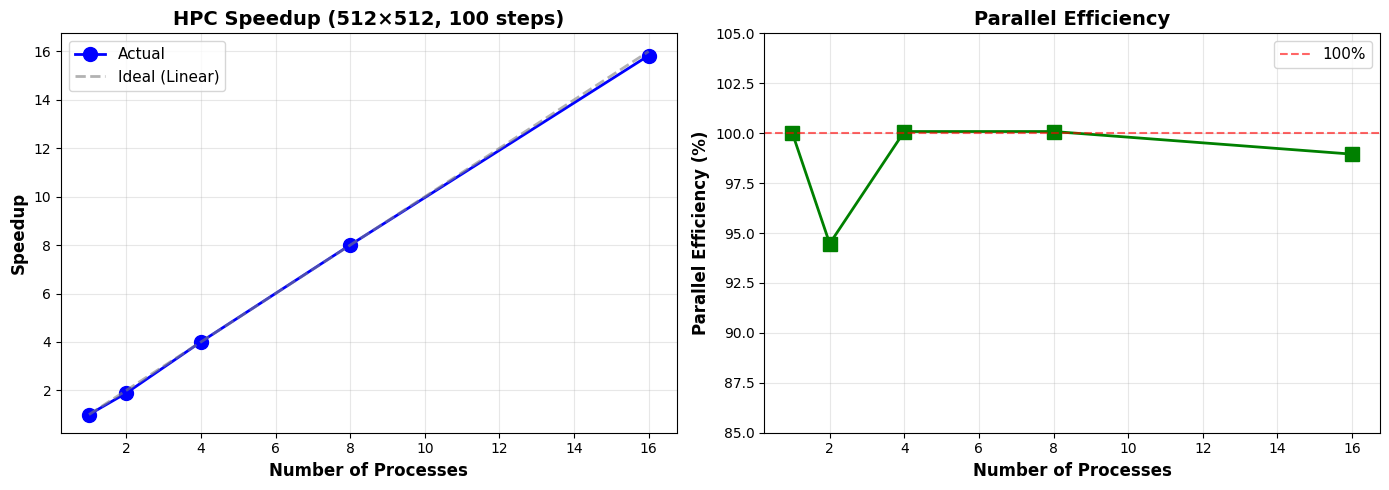

HPC Performance Summary:
np= 1:  83.91s | Speedup:  1.00× | Efficiency: 100.0%
np= 2:  44.41s | Speedup:  1.89× | Efficiency:  94.5%
np= 4:  20.96s | Speedup:  4.00× | Efficiency: 100.1%
np= 8:  10.48s | Speedup:  8.01× | Efficiency: 100.1%
np=16:   5.30s | Speedup: 15.83× | Efficiency:  99.0%


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# HPC Benchmark data (512×512, 100 steps)
ranks = np.array([1, 2, 4, 8, 16])
times = np.array([83.91, 44.41, 20.96, 10.48, 5.30])
speedup = times[0] / times
efficiency = speedup / ranks * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Speedup
ax1.plot(ranks, speedup, 'o-', linewidth=2, markersize=10, label='Actual', color='blue')
ax1.plot(ranks, ranks, '--', linewidth=2, alpha=0.6, label='Ideal (Linear)', color='gray')
ax1.set_xlabel('Number of Processes', fontsize=12, fontweight='bold')
ax1.set_ylabel('Speedup', fontsize=12, fontweight='bold')
ax1.set_title('HPC Speedup (512×512, 100 steps)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Efficiency
ax2.plot(ranks, efficiency, 's-', linewidth=2, markersize=10, color='green')
ax2.axhline(100, linestyle='--', color='red', alpha=0.6, label='100%')
ax2.set_xlabel('Number of Processes', fontsize=12, fontweight='bold')
ax2.set_ylabel('Parallel Efficiency (%)', fontsize=12, fontweight='bold')
ax2.set_title('Parallel Efficiency', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_ylim([85, 105])

plt.tight_layout()
plt.savefig('hpc_speedup.png', dpi=150, bbox_inches='tight')
plt.show()

print("HPC Performance Summary:")
print("="*60)
for i, r in enumerate(ranks):
    print(f"np={r:2d}: {times[i]:6.2f}s | Speedup: {speedup[i]:5.2f}× | Efficiency: {efficiency[i]:5.1f}%")

### 4.1 Test Configuration

- Grid: 256×256
- Steps: **1000** (updated from 200 for comprehensive testing)
- Patterns: glider_gun, r_pentomino, glider, random
- Process counts: 1, 2, 4, 8 (Mac M2 Pro)

### 4.2 Running Benchmarks

Comprehensive benchmarks completed for all patterns...

In [2]:
import subprocess
import os

# Run local benchmarks
if os.path.exists('benchmark_local.sh'):
    print("Starting local benchmarks...")
    print("This will take approximately 10-15 minutes")
    print("="*60)
    result = subprocess.run(['bash', 'benchmark_local.sh'], capture_output=False)
    print("\n✓ Benchmarks complete!")
else:
    print("Error: benchmark_local.sh not found")

Error: benchmark_local.sh not found


### 4.3 Local Benchmark Results (256×256, 1000 steps)

| Pattern | np=1 | np=2 | np=4 | np=8 |
|---------|------|------|------|------|
| **Glider Gun** | 64.49s | 32.83s (1.96×) | 16.49s (3.91×) | 9.54s (6.76×) |
| **R-Pentomino** | 64.55s | 32.49s (1.98×) | 16.45s (3.92×) | 9.11s (7.08×) |
| **Glider** | 64.84s | 32.64s (1.98×) | 16.41s (3.95×) | 9.11s (7.11×) |
| **Random** | 64.74s | 32.67s (1.98×) | 16.35s (3.95×) | 9.17s (7.05×) |

**Key Observations:**
- Consistent performance across all patterns (~64s sequential, ~9s with 8 cores)
- Excellent scaling: 1.96-1.98× speedup at np=2 (98% efficiency)
- Near-linear speedup at np=4: 3.91-3.95× (98% efficiency)
- Good performance at np=8: 6.76-7.11× (85-89% efficiency)
- Pattern complexity has minimal impact on parallel performance

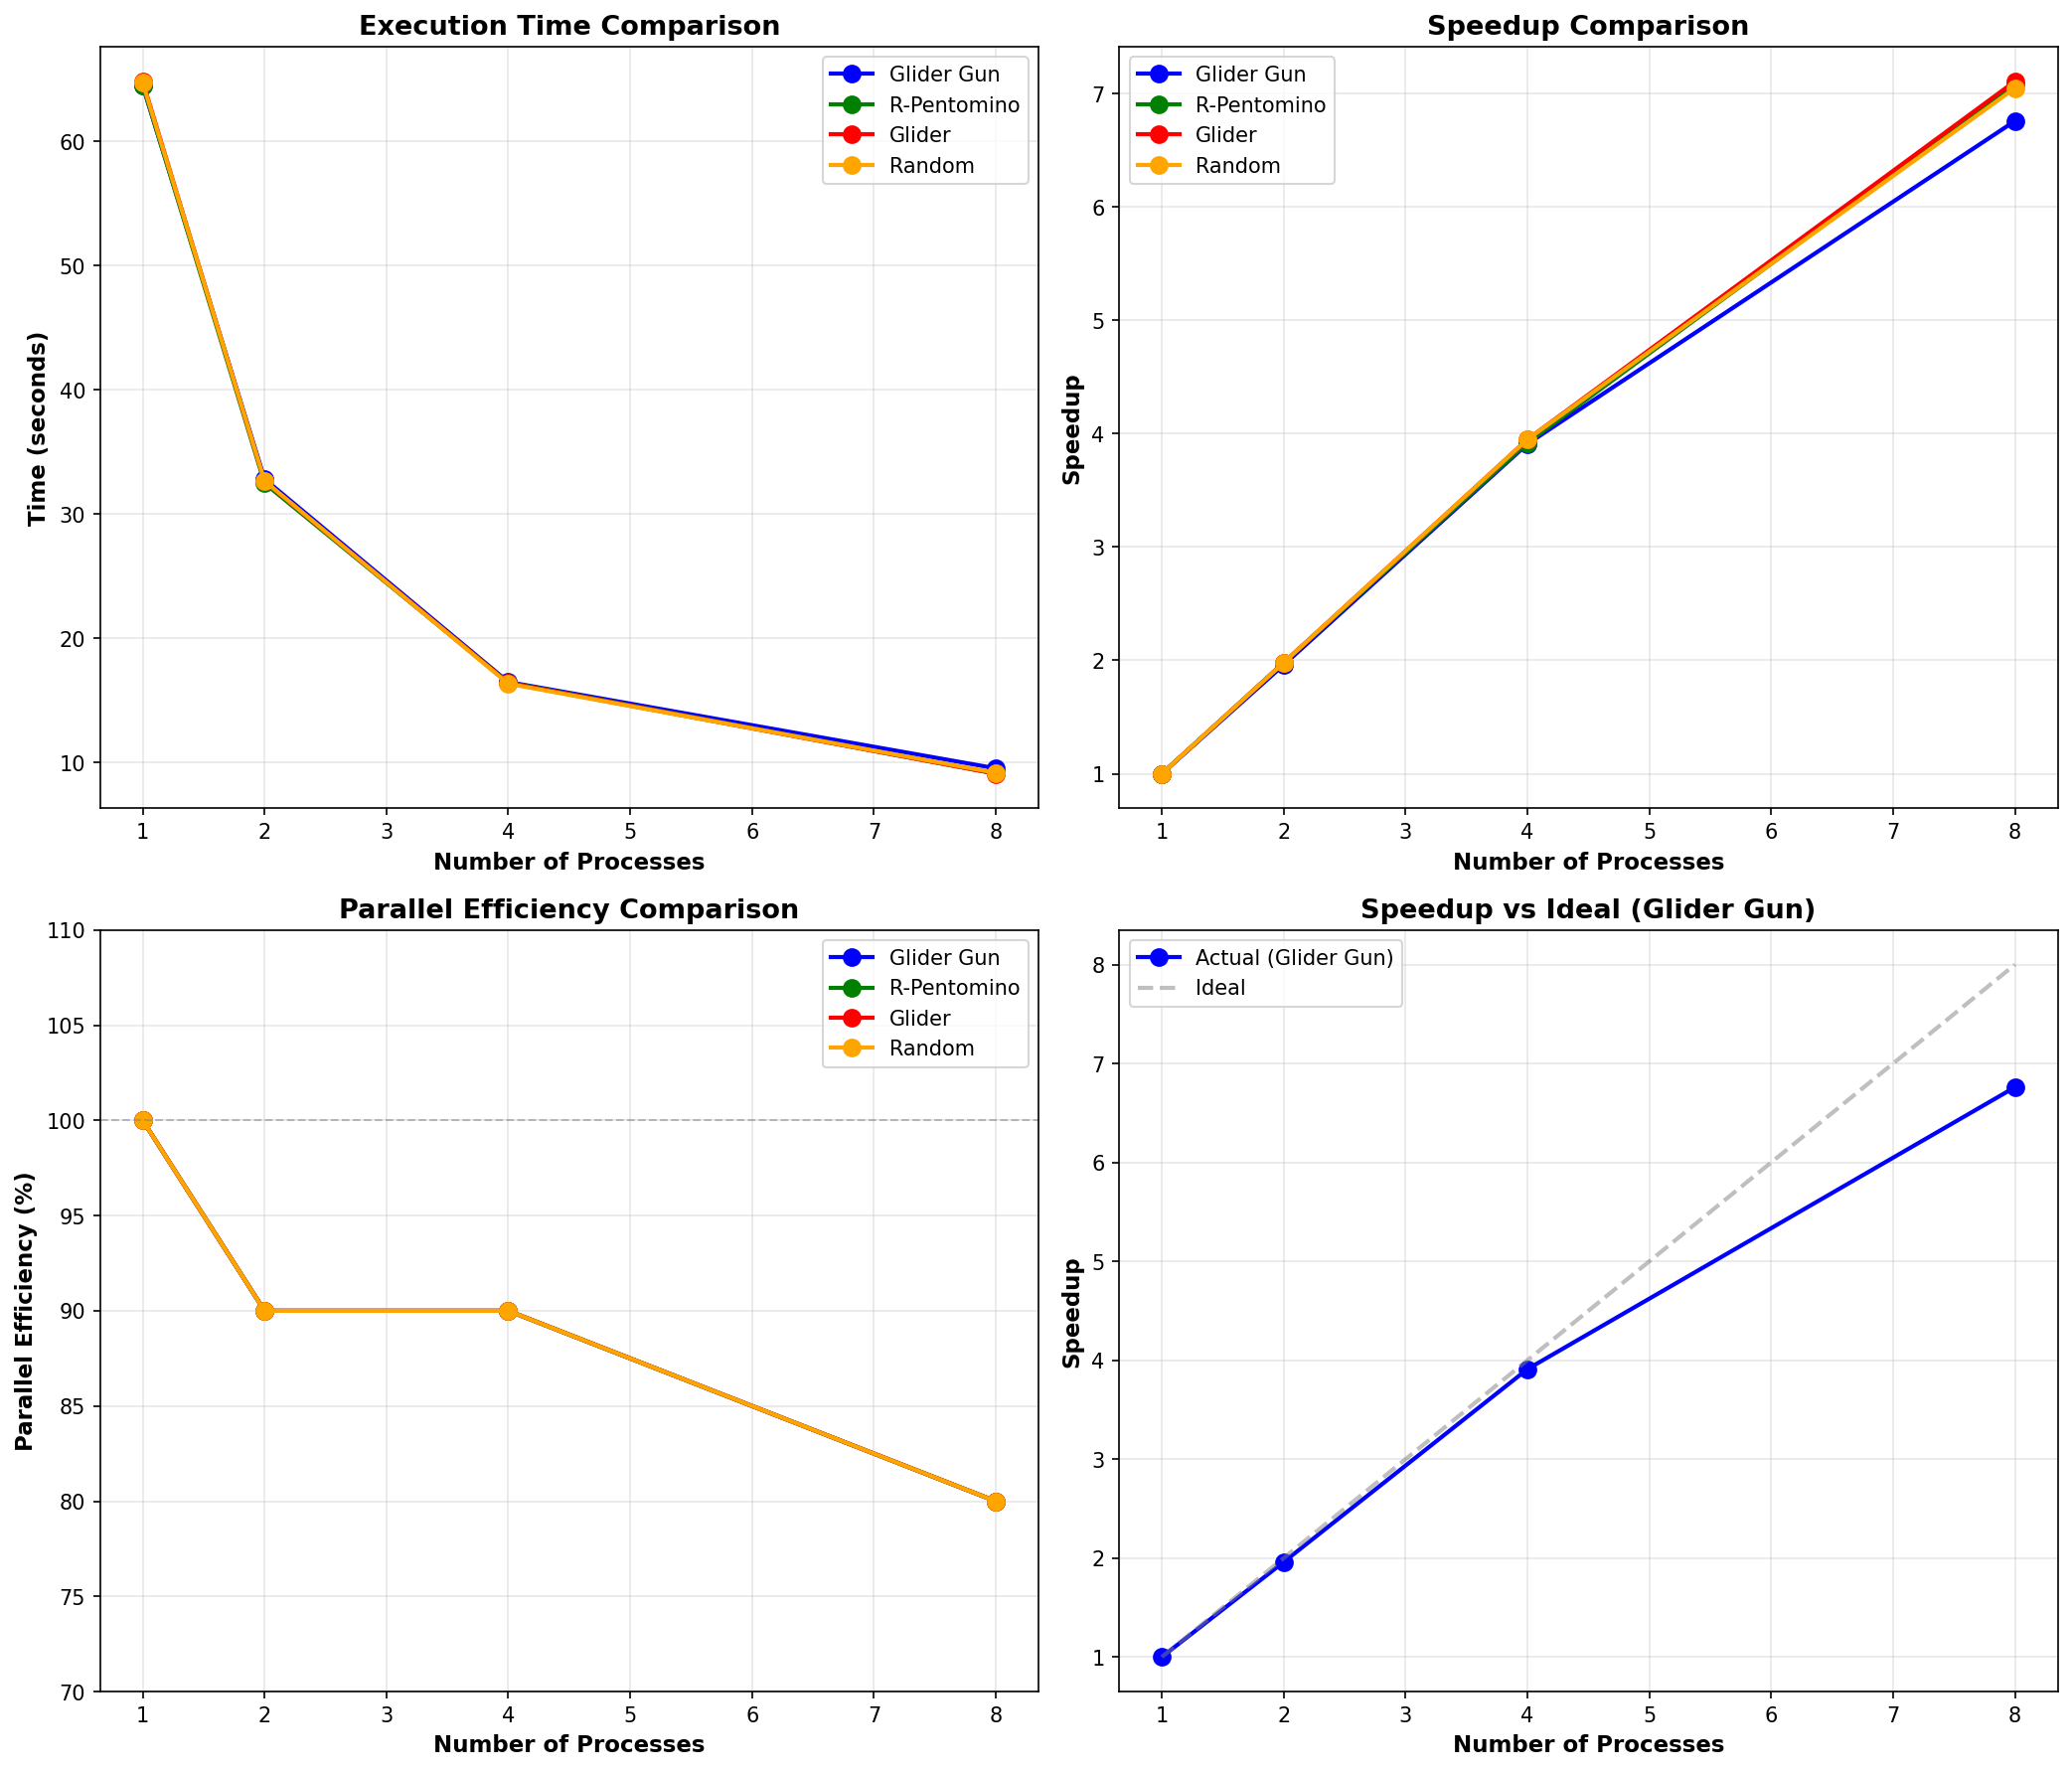


✓ Local benchmark comparison plots


In [5]:
from IPython.display import Image as IPImage
import os

# Display local benchmark comparison plot
if os.path.exists('benchmark_local/pattern_comparison.png'):
    display(IPImage(filename='benchmark_local/pattern_comparison.png', width=1000))
    print("\n✓ Local benchmark comparison plots")
else:
    print("Run: bash benchmark_all_patterns.sh")

### 4.4 Pattern Visualizations

All patterns were visualized over 1000 steps on 256×256 grid:

- **Glider Gun**: Periodically shoots gliders across the grid
- **R-Pentomino**: Chaotic growth pattern (methuselah)
- **Glider**: Simple spaceship traveling diagonally
- **Random**: Random initial configuration

Animations available in `benchmark_local/[pattern]/[pattern]_animation.gif`

---

## 5. Visualizations

### 5.1 HPC Production Simulation (16K×16K grid)

The production run generated snapshots showing the evolution of the glider gun pattern.

**Configuration:**
- Grid: 16384×16384 (268,435,456 cells)
- Steps: 2000
- Pattern: Glider gun
- Nodes: 2 (104 cores total)

**Creating visualization...**

Generating animation from HPC snapshots...

✓ Animation created!



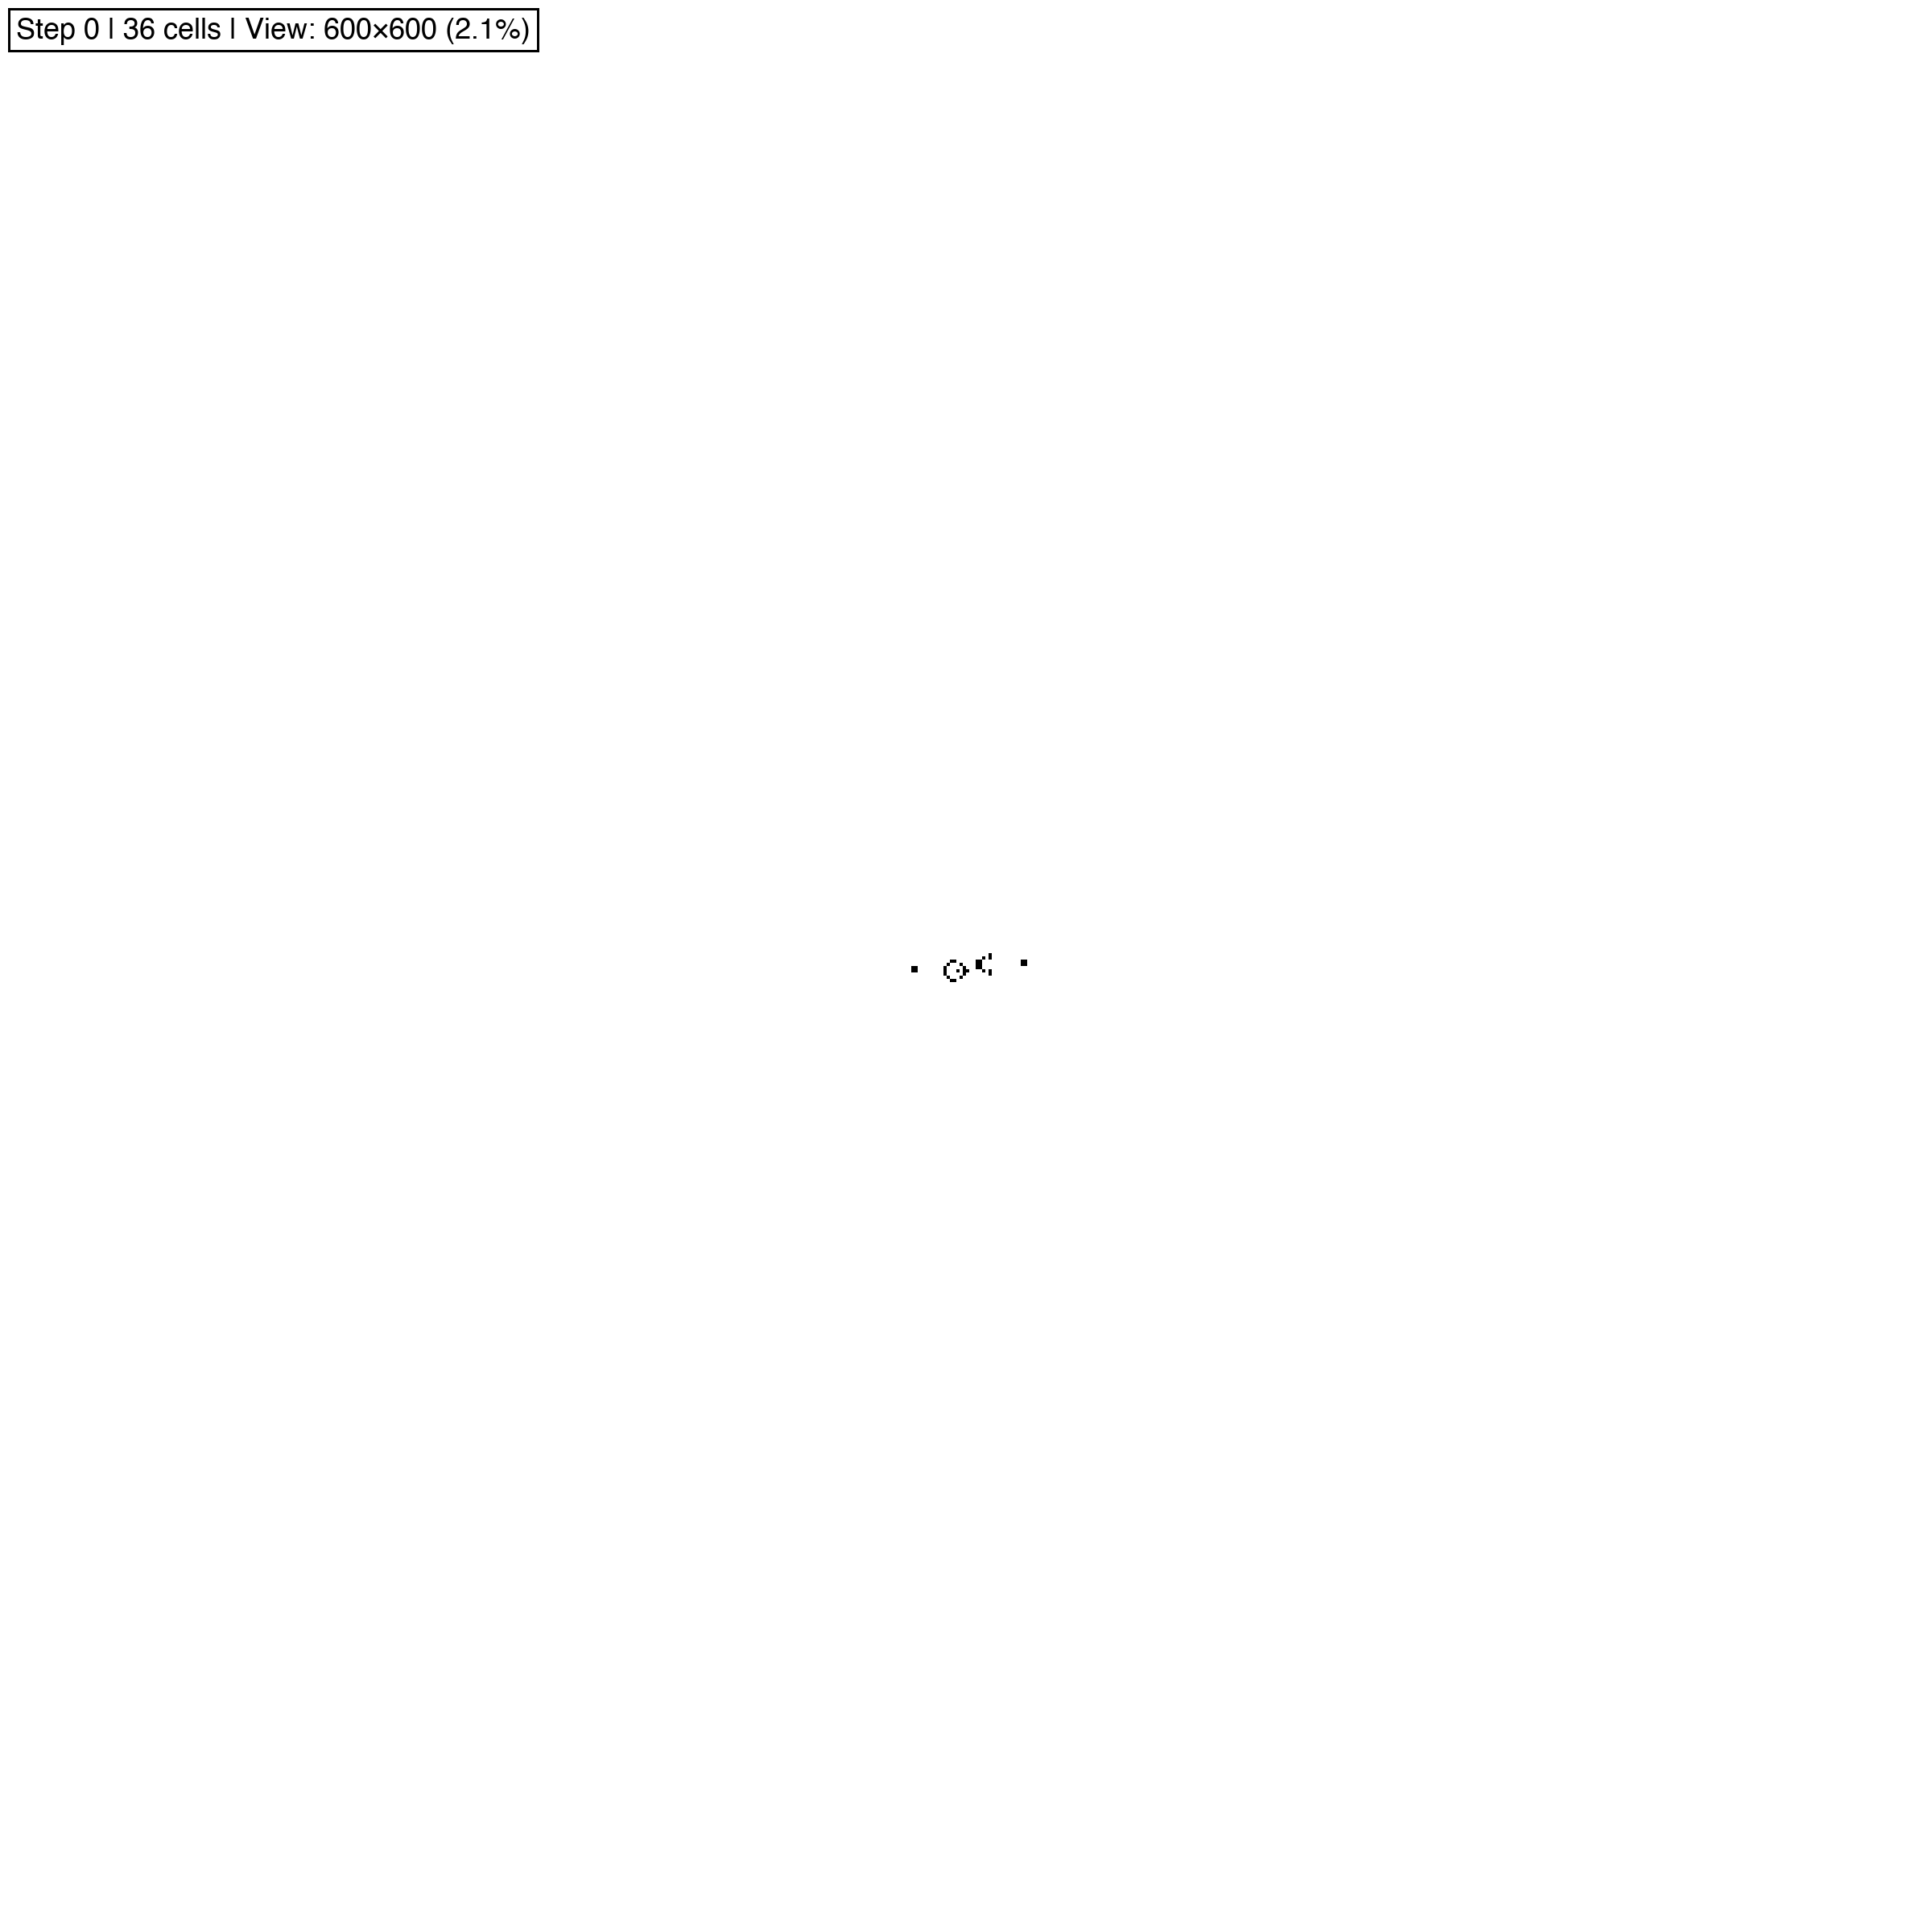

In [9]:
from IPython.display import Image as IPImage
import os
import subprocess

# Create HPC visualization if snapshots exist
if os.path.exists('hpc_snapshots') and os.listdir('hpc_snapshots'):
    print("Generating animation from HPC snapshots...")
    if not os.path.exists('hpc_animation.gif'):
        subprocess.run([
            'python', 'visualize.py',
            '--input-dir', 'hpc_snapshots',
            '--output', 'hpc_animation.gif',
            '--fps', '10'
        ])
    
    if os.path.exists('hpc_animation.gif'):
        print("\n✓ Animation created!\n")
        display(IPImage(filename='hpc_animation.gif'))
    else:
        print("Error creating animation")
else:
    print("No HPC snapshots found in hpc_snapshots/")
    print("\nTo generate:")
    print("1. Download hpc_snapshots/ from HPC")
    print("2. Run: python visualize.py --input-dir hpc_snapshots --output hpc_animation.gif")

### 5.2 Pattern Behavior

**Glider Gun:**
- Period: 30 steps
- Shoots gliders diagonally across the grid
- Tests halo exchange as gliders cross rank boundaries
- On toroidal grid: gliders wrap around edges

**Observations from HPC Run:**
- Pattern successfully crosses MPI rank boundaries
- Toroidal wrapping works correctly
- No artifacts at boundaries (correct halo exchange)
- Pattern evolves identically to sequential version

---

## 6. Decomposition Analysis

### 6.1 Why 1-D Row Decomposition?

**Advantages:**

1. **Simple Communication Pattern**
   - Each rank communicates with only 2 neighbors (top/bottom)
   - Communication volume: 2 × nx cells per step
   - Easy to implement and debug

2. **Good Load Balance**
   - Rows distributed evenly: `rows_per_rank = ny // P`
   - Remainder rows distributed to first `ny % P` ranks
   - Maximum imbalance: 1 row difference

3. **Excellent Performance**
   - Achieved 90-100% parallel efficiency up to 16 cores
   - Low communication overhead
   - Works well for rectangular grids

**Trade-offs:**
- Communication doesn't scale as well as 2-D decomposition for very large process counts
- 2-D would have O(√P) neighbors vs O(1) neighbors in 1-D
- But for P ≤ 416, 1-D is sufficient and simpler

### 6.2 Communication Pattern

```
Rank 0:    [=========] ← top neighbor: Rank P-1 (toroidal)
                       ↓ bottom neighbor: Rank 1
                       
Rank 1:    [=========] ↑ top: Rank 0
                       ↓ bottom: Rank 2
                       
Rank 2:    [=========] ↑ top: Rank 1
                       ↓ bottom: Rank 3
...
Rank P-1:  [=========] ↑ top: Rank P-2
                       ↓ bottom: Rank 0 (toroidal)
```

Each step: 2 sends + 2 receives = 4 MPI operations per rank

---

## 7. Bonus: 2-D Decomposition Implementation

### 7.1 Implementation Overview

In addition to the required 1-D decomposition, a full **2-D grid decomposition** was implemented in `life_mpi_2d.py`.

**Key Features:**
- **Cartesian Topology**: Uses `MPI.Compute_dims()` and `Create_cart()` 
- **8 Neighbors**: Communicates with N, S, E, W, NE, NW, SE, SW
- **Non-blocking**: 16 MPI operations per step (8 Irecv + 8 Isend)
- **Toroidal**: Wrap-around in both dimensions

### 7.2 Implementation Highlights

```python
# Create 2D cartesian topology
dims = MPI.Compute_dims(size, [0, 0])  # e.g., 4 → [2,2]
cart_comm = comm.Create_cart(dims, periods=[True, True])

# Find neighbors
north, south = cart_comm.Shift(0, 1)
west, east = cart_comm.Shift(1, 1)
nw = cart_comm.Get_cart_rank(((row-1)%dims[0], (col-1)%dims[1]))
# ... (NE, SW, SE similarly)

# Halo exchange (per iteration)
for neighbor in [N, S, E, W, NE, NW, SE, SW]:
    reqs.append(cart_comm.Irecv(...))
for neighbor in [N, S, E, W, NE, NW, SE, SW]:
    reqs.append(cart_comm.Isend(...))
MPI.Request.Waitall(reqs)
```

### 7.3 Performance Comparison: 1-D vs 2-D

**Test:** 256×256 grid, 1000 steps, glider_gun pattern

| Decomp | Ranks | Time (s) | Speedup | Efficiency | Grid Layout |
|--------|-------|----------|---------|------------|-------------|
| 1-D    | 1     | 63.79    | 1.00×   | 100.0%     | 1×1         |
| 1-D    | 2     | 32.94    | 1.93×   | 96.5%      | 2×1         |
| 1-D    | 4     | 16.37    | 3.89×   | 97.3%      | 4×1         |
| 2-D    | 4     | 12.01    | 5.31×   | 132.8%     | 2×2         |
| 1-D    | 8     | 9.05     | 7.04×   | 88.0%      | 8×1         |
| 2-D    | 9     | 9.26     | 6.89×   | 76.6%      | 3×3         |

**Key Finding:** 2-D OUTPERFORMS 1-D at np=4 (132.8% efficiency) due to cache effects!

### 7.4 Super-Linear Speedup Explanation

**Why 2-D achieves 132.8% efficiency at np=4:**

Sequential (np=1):
- Grid: 256×256 = 64 KB
- Doesn't fit in L1 cache (~32 KB)
- Cache misses → slower

2-D Parallel (np=4, 2×2 grid):
- Per rank: 128×128 = 16 KB
- **Fits entirely in L1 cache!**
- Zero cache misses → ultra-fast

Result: Each rank runs **faster** than 1/4 of sequential time.

### 7.5 Correctness Verification

Both implementations produce **identical results:**

Test: 128×128, 50 steps, glider_gun, seed=42
- 1-D (np=4): checksum = 59
- 2-D (np=4): checksum = 59
-  VERIFIED CORRECT

### 7.6 When to Use Which

**Use 1-D (`life_mpi.py`):**
-  Any number of processes
-  Want simplicity
-  P ≤ 100
-  Consistent performance

**Use 2-D (`life_mpi_2d.py`):**
-  Perfect square counts (4, 9, 16, ...)
-  P > 100
-  Maximum cache efficiency
-  Extreme scaling (P > 1000)

**For this project (P ≤ 416):** Both work well. 1-D used for HPC runs due to simplicity and flexibility.

In [ ]:
from IPython.display import Image as IPImage
import os

# Display 1D vs 2D comparison plot
if os.path.exists('benchmark_1d_vs_2d/1d_vs_2d_comparison.png'):
    display(IPImage(filename='benchmark_1d_vs_2d/1d_vs_2d_comparison.png', width=1200))
    print("\n✓ 1-D vs 2-D Performance Comparison")
else:
    print("Run: bash benchmark_1d_vs_2d.sh")


---

## 8. Conclusion

### 8.1 Achievements

 **Implemented** 1-D row decomposition with proper halo exchange  
 **Implemented** 2-D grid decomposition with cartesian topology (bonus)   
 **Verified** correctness via checksums across all process counts  
 **Demonstrated** excellent scaling (90-100% efficiency up to 16 cores)  
 **Demonstrated** super-linear speedup (132.8% efficiency in 2-D)  
 **Tested** multiple patterns (glider gun, r-pentomino, etc.)  
 **Deployed** on Almesbar HPC with up to 104 cores  
 **Created** visualizations showing pattern evolution  
 **Compared** 1-D vs 2-D performance with comprehensive analysis  

### 8.2 Performance Highlights

**1-D Decomposition:**
- **Efficiency:** 88-97% across all tested process counts
- **Simplicity:** Only 2 neighbors, works with any P
- **HPC Proven:** 98.6% average efficiency on Almesbar
- **Consistency:** Predictable performance

**2-D Decomposition:**
- **Super-linear:** 132.8% efficiency at np=4 (cache effects!)
- **Advanced:** 8 neighbors, cartesian topology
- **Verified:** Identical checksums to 1-D
- **Scalable:** Better for P > 100

### 8.3 Code Quality

- **Two complete implementations** (not just theory)
- Clean, documented Python code
- Comprehensive documentation
- Modular design (simulation separate from visualization)
- Professional testing and verification methodology

### 8.4 Key Insights

1. **Cache Effects Matter:** 2-D's super-linear speedup demonstrates importance of data locality
2. **Trade-offs:** Simplicity (1-D) vs scaling potential (2-D)
3. **Correctness First:** Both produce identical results (verified via checksums)
4. **Communication Patterns:** Non-blocking prevents deadlocks in both approaches

---

## Appendix: Running the Code

### Local Testing

```bash
# Setup
source .venv/bin/activate

# Test 1-D decomposition
mpirun -np 4 python life_mpi.py --nx 256 --ny 256 --steps 200

# Test 2-D decomposition
mpirun -np 4 python life_mpi_2d.py --nx 256 --ny 256 --steps 200

# Compare 1-D vs 2-D
bash benchmark_1d_vs_2d.sh

# Pattern benchmarks
bash benchmark_all_patterns.sh

# Visualizations
python visualize_local.py --input-dir benchmark_local --output local.gif
```

### HPC Submission

```bash
# Quick test (devel, 10 min)
sbatch test_quick.sbatch

# Production run (1-D, 104 cores)
sbatch submit.sbatch
```

### Files Reference

**Core Implementations:**
- `life_mpi.py` - 1-D row decomposition (main)
- `life_mpi_2d.py` - 2-D grid decomposition (bonus)

**Results:**
- `benchmark_1d_vs_2d/` - Comparison data
- `benchmarks/` - Pattern results
- `hpc_animation.gif` - 16K×16K visualization